In [6]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append("./slim")
from nets import inception
from preprocessing import inception_preprocessing

tf.reset_default_graph()
session = tf.Session()

image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        with open(f,'rb') as img:
            image_raw = tf.image.decode_jpeg(img.read(), channels=3)
            image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
            out.append(image)
    return session.run([out])[0]

from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = 'model'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)

def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

def f(x):
    return x / 2 + 0.5

class_names = []
for item in names:
    class_names.append(names[item])

In [3]:
images = transform_img_fn(['data/violin.JPEG'])
image = images[0]

In [4]:
import xdeep.local.perturbation.xdeep_image as xdeep_image
explainer = xdeep_image.ImageExplainer(predict_fn, class_names)

Initialize default 'lime', 'cle', 'anchor' explainers. Please explicitly initialize 'shap' explainer before use it.



LIME Explanation

Explanation for label violin, fiddle:
Local Prediction:     1.122
Original Prediction:  0.895

Explanation for label cello, violoncello:
Local Prediction:     0.162
Original Prediction:  0.101

Explanation for label acoustic guitar:
Local Prediction:     0.030
Original Prediction:  0.001



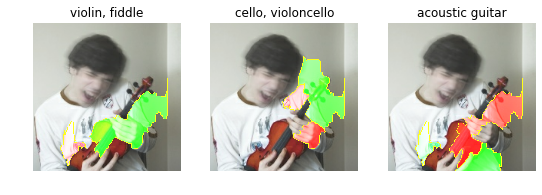

In [4]:
explainer.explain('lime', image, top_labels=3)

explainer.show_explanation('lime', deprocess=f, positive_only=False)

/home/zijianzhang0226/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/zijianzhang0226/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/zijianzhang0226/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



CLE Explanation

Explanation for label violin, fiddle:
Local Prediction:     0.936
Original Prediction:  0.895

Explanation for label cello, violoncello:
Local Prediction:     0.107
Original Prediction:  0.101

Explanation for label acoustic guitar:
Local Prediction:     0.003
Original Prediction:  0.001



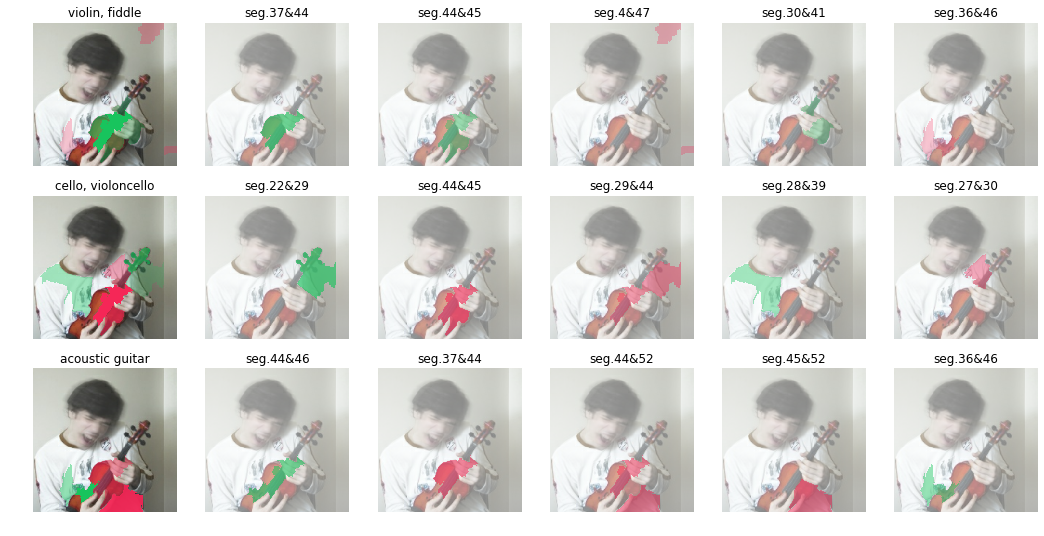

In [7]:
explainer.explain('cle', image, top_labels=3)

explainer.show_explanation('cle', deprocess=f, positive_only=False)

True pred 890


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Anchor Explanation

Prediction  890
Confidence  0.9896142433234422


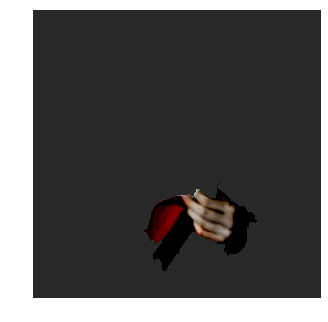

In [4]:
explainer.explain('anchor', image)

explainer.show_explanation('anchor')

100%|██████████| 1/1 [00:37<00:00, 37.34s/it]


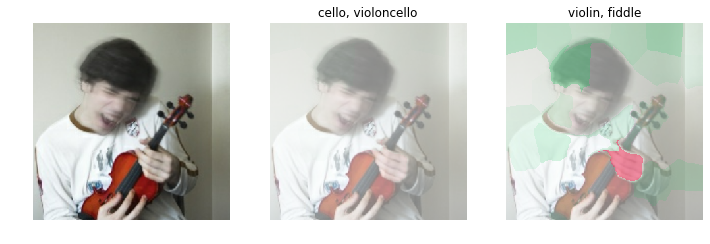

In [5]:
from skimage.segmentation import slic
segments_slic = slic(image, n_segments=50, compactness=30, sigma=3)
explainer.initialize_shap(n_segment=50, segment=segments_slic)
explainer.explain('shap',image,nsamples=400)
explainer.show_explanation('shap',deprocess=f)